# Individual Assignment

The goal of the individual assignment is to first preprocess a single subject’s data and afterwards perform a simple first-level analysis.

We will use the "NYU Slow Flanker" dataset from [OpenNeuro](https://openneuro.org/datasets/ds000102/versions/00001). In this study, 26 healthy adults underwent MRI scanning while performing an event-related Eriksen Flanker task.



## Setting up the environment (~2 min)

- Create directories
- Install dependencies (i.e., Nipype, Nilearn, FSL)
- Download data

Note: If your runtime gets disconnected, you have to rerun the cell.

In [ ]:
import os

!mkdir /data
!mkdir -p /output/working_dir

!pip install nilearn
!pip install nipype

# install fsl
!sudo apt-get remove -y --purge man-db
!apt-get update
!apt-get install neurodebian-archive-keyring
!add-apt-repository "deb http://neuro.debian.net/debian bionic main contrib non-free"
!apt-get install fsl-core

fslpath="/usr/share/fsl/5.0" 
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")
!. ${FSLDIR}/etc/fslconf/fsl.sh
!export FSLDIR PATH

os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

# add mni template to fsl dir
!mkdir /usr/share/fsl/5.0/data/standard
!wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O /content/mniatlas.zip
!unzip /content/mniatlas.zip -d /usr/share/fsl/5.0/data/standard

# download dataset
#!wget 'https://ucloud.univie.ac.at/index.php/s/qKFm0f0Q98etPNG/download' -O /content/ds000102.zip
#!unzip /content/ds000102.zip -d /data


## Setup experiment parameter

In [2]:
# set paths for experiment dir, working dir and output dir
working_dir = "/output/working_dir"

# define the ID of your subject

# define variables for number of slices, tr and ta

In [ ]:
# Import necessary packages and modules

---
Inspect Data

In [ ]:
# bloth poth the anatomical and functional raw image

# check the shape of both files

# -> everything alright?

## Prepreocessing pipeline

### Input/Output Stream

In [ ]:
## Setup nodes

# Input stream (SelectFiles)

# Output stream (DataSink)

### Temporal Preprocessing

In [ ]:
# remove first four volumes (fsl.ExtractROI)

# slicetime correction (fsl.SliceTimer)
  # interleaved

# realignment/motion correction (fsl.MCFLIRT)
  # register to mean volume
  # save motion parameter
  
# smooting (fsl.IsotropicSmooth)
  # fwhm = 4
  
# artefact detection (algorithms.rapidart.ArtifactDetect)
  # norm_threshold=2,
  # zintensity_threshold=3,
  # mask_type='spm_global',
  # parameter_source='FSL',
  # use_differences=[True, False],
  # plot_type='svg')

### Coregistration & Normalization

For the coregistration (i.e., aligning the functional and antomical image) and the normalization (i.e., warping our data to the MNI template), we will create a sub-worflow that will be included in the main workflow. To limit the complexity of the assignment (the FSL implementation of coregistration and normalization tends to be rather complicated), we provide you with function that generate pre-defined workflows (```create_fsl_coregflow``` and ```create_fsl_normflow```, respectively). You can have a look at the functions on our [GitHub repository](https://github.com/lrsktr/tewa-neuroimaging/blob/main/Individual-project/scripts/fsl-spatial-preproc.py)

Your task is to connect these sub-workflows with the main workflow.

*If you want to make a deep-dive into spatial preprocessing steps, check out this [notebook on coregistration and normalization](https://colab.research.google.com/github/ljchang/dartbrains/blob/master/content/Preprocessing.ipynb#scrollTo=yJAF3Lrujyrg) by [Luke Chang](http://lukejchang.com/) and colleagues from the Dartmouth College (they cover the mathematical basics of these preprocessing steps and demonstrate how to implement them using [fmriprep](https://fmriprep.readthedocs.io/) - a pipeline built on top of Nipype*.

In [ ]:
# install scripts for coreg and normalization workflow
!wget -O fslspatial.py https://ucloud.univie.ac.at/index.php/s/zVLcnufuQDbTMgI/download

In [ ]:
# import custom coregistration and normalization scripts
from fslspatial import create_fsl_coregflow, create_fsl_normflow

mni_template = os.path.join(
    os.getenv('FSLDIR'), 'data/standard/MNI152_T1_2mm_brain.nii.gz')

coreg_wf = create_fsl_coregflow(
    base_directory=working_dir, apply_to_epis=True)

norm_wf  = create_fsl_normflow(
    base_directory=working_dir, reference=mni_template)

Running the functions will create two sub-workflows. We will visualize them so you get an overall idea and know how the nodes are named:

221003-11:25:41,250 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


221003-11:25:41,416 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /output/working_dir/norm_wf/graph.png (graph2use=colored, simple_form=True).



Coregistration Workflow:


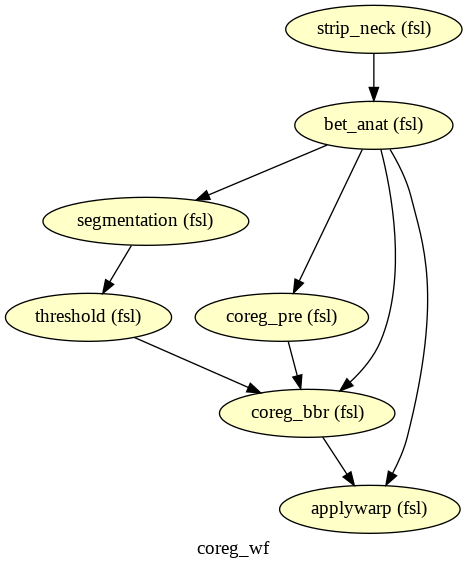

In [6]:
from IPython.display import Image

coreg_wf.write_graph(
    graph2use="colored", format="png", simple_form=True)

norm_wf.write_graph(
    graph2use="colored", format="png", simple_form=True)

print("\nCoregistration Workflow:")
Image(filename=f"{working_dir}/{coreg_wf}/graph.png")

Normalization Workflow:


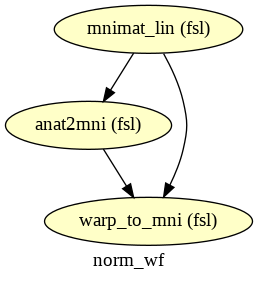

In [7]:
print("Normalization Workflow:")
Image(filename=f"{working_dir}/{norm_wf}/graph.png")

### Connect Nodes

Finally, the nodes have to be connected with each other. Again, to limit complexity, the comments below provide some guidance. We will also discuss this in the practicals. 

To connect the main workflow with the subworkflow, you will need to use a special syntax (see the cell below or refer to notebook 04 for an example). To get the names of coregistration and normalization nodes, refer to the graphs above.

In [ ]:
# connect all nodes
wf.connect([#(selectfiles -> extractROI)
            #(extractROI -> slicetimer)
            #(slicetimer -> realigner)
            #(realigned func images as input for artifact detection)
            #(realignment parameter file as input realignment parameters for artifact detection)

            #(selectfiles, coreg_wf,  [("anat", "strip_neck.in_file")]),          # example for accessing nodes within a a workflow
            
            #(mean realigned func image as input for Pre-alignment and bbr coreg) 

            #(realigned func images as input for applying coreg warp)
            

            #(restored image from segmentation as input for lin. transformation of t1 to mni)
            #(restored image from segmentation as input for non-lin. transformation of t1 to mni)
            
            #(output of applied coreg warp as input file for warp of func data to mni template)

            #(output of warp of func data to mni template as input for smoother)

            # Store the following files using Datasink
            ## transformation parameters obtained by realignment
            ## unsmoothed functional file warped to mni 
            ## smoothed functional file warped to mni
            ## skullstripped anatomical image
            ## anatomical image in mni space (warped_file)
            ## outlier and plot files of artifact detection
])

### Run workflow

## Sanity checks

### Initial checks


In [ ]:
#inspect shape of preprocessed image (does it make sense?)
#plot preprocessed image

### Motion correction


In [ ]:
#inspect motion parameters by plotting the .par file

### Normalization

Visualize normalization results by overlaying raw and normalized files with MNI template mask

## First-level analysis

Using the preprocessed files, perform a first-level analysis. The steps are:

- Setup Model (using Nilearn's ```FirstLevelModel```)

- Fit the model to the data
  - use the events file stored in the data directory
  - use the motion parameter as confounds
  
  
- Plot the design matrix
- Define the contrasts
  - congruent_correct > baseline
  - incongruent_correct > baseline
  - incongruent-congruent
  - congruent-incongruent
  - motion parameters > baseline
- Calculate a z-statistics map for each contrast
- Plot the z-statistics maps (using the subject's warped anatomical image as background)
